In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.optimizers import RMSprop, Adam
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-03-05 19:43:56.453208: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 19:43:56.453326: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 19:43:56.600281: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


github link: https://github.com/colites/Cancer-data

The objective of this project is to identify whether the small image patches are cancer or they are normal. To be able to correctly classify these images, this project will decide on the best performing CNN model from the models that will be tested in the notebook. We will be using the CNN architecture for the model because CNN based models perform well in image analysis tasks. To summarize how CNN models work at a high level, filters are applied in the convolution layers to extract features from the images. The deeper the layer, the more complex the features that are extracted in the convolution layers. After every convolution layer there is a pooling layer whose function is to reduce the spatial dimensions of the input to the next convolution layer, helping prevent overfitting. Finally, there is a dense classification layer that gathers all the features acquired from the convolution layers and performs the classification using the features that were gathered.

To get the best model possible, there will be hyper-parameter tuning to test the effects of various modifications to the CNN structure such as the number of layers in the CNN model or the optimizer used when compiling the CNN model. The metric used to determine the effectiveness of the model will be the AUC score, which is the area under the ROC curve with a higher AUC score being a indicator of model that has good discriminative power between the classes.

To begin this project, we will first do basic exploratory data analysis to see the basic characteristics of the dataset such as the shape of the images and to gain a better idea of what kind of features can be extracted from the images.

In [6]:
train_labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

train_img_directory = '/kaggle/input/histopathologic-cancer-detection/train'
test_img_directory = '/kaggle/input/histopathologic-cancer-detection/test'

train_image_files = os.listdir(train_img_directory)
test_image_files = os.listdir(test_img_directory)
image_ids = [file.split('.')[0] for file in test_image_files] 

## create a label dataframe for the test data
submission = pd.DataFrame(image_ids, columns=['id'])
submission['label'] = ''

In [3]:
train_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [8]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [4]:
submission.head()

,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,


For this dataset, an label of 0 is normal. 

An label of 1 means there is cancer.

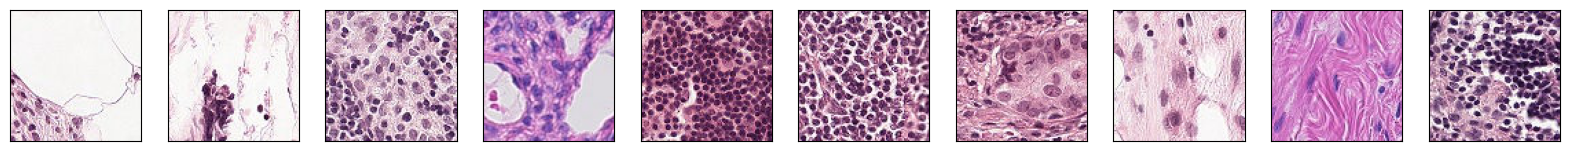

In [4]:
fig = plt.figure(figsize=(20, 5))
for i in range(10):
    ax = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
    im = Image.open(train_img_directory +'/'+ train_labels['id'][i] + '.tif')
    plt.imshow(im)
    

label for the image is: 0, this is a normal image
the width of the image is : 96
the height of the image is :96


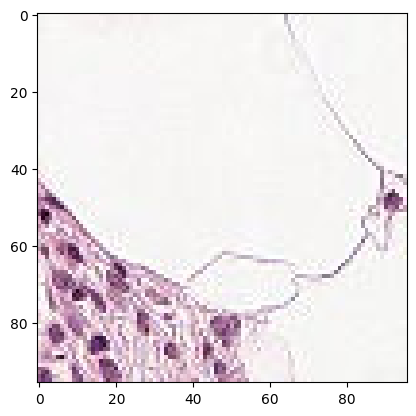

In [9]:
im = Image.open(train_img_directory +'/'+ train_labels['id'][0] + '.tif')
image_label = train_labels['label'][0]
print(f'label for the image is: {image_label}, this is a normal image')
width, height = im.size
print(f'the width of the image is : {width}')
print(f'the height of the image is :{height}')
plt.imshow(im)


(96, 96, 3)


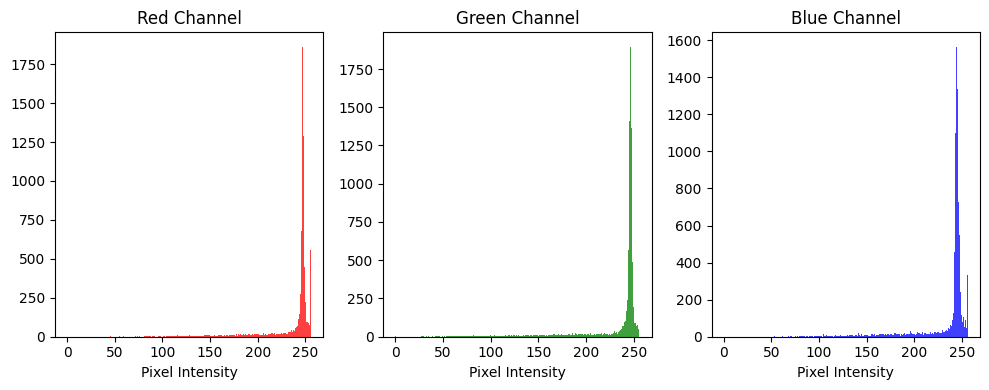

In [10]:
#### We will make a pixel intensity map to see the pixel intensity of the image above, the intensity can have patterns that will be picked up by the GAN
#### Inspired by the analysis done in https://www.codementor.io/@innat_2k14/image-data-analysis-using-numpy-opencv-part-1-kfadbafx6 
pixel_values = np.array(im)
print(pixel_values.shape)

# Separate the RGB channels
r, g, b = pixel_values[:,:,0], pixel_values[:,:,1], pixel_values[:,:,2]

# Plot the histogram of pixel intensities for each channel
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)  # Red channel
plt.hist(r.flatten(), bins=256, range=(0, 256), color='red', alpha=0.75)
plt.title('Red Channel')
plt.xlabel('Pixel Intensity')

plt.subplot(1, 3, 2)  # Green channel
plt.hist(g.flatten(), bins=256, range=(0, 256), color='green', alpha=0.75)
plt.title('Green Channel')
plt.xlabel('Pixel Intensity')

plt.subplot(1, 3, 3)  # Blue channel
plt.hist(b.flatten(), bins=256, range=(0, 256), color='blue', alpha=0.75)
plt.title('Blue Channel')
plt.xlabel('Pixel Intensity')

plt.tight_layout()
plt.show()

label for the image is: 1, this is a Cancer image
the width of the image is : 96
the height of the image is :96


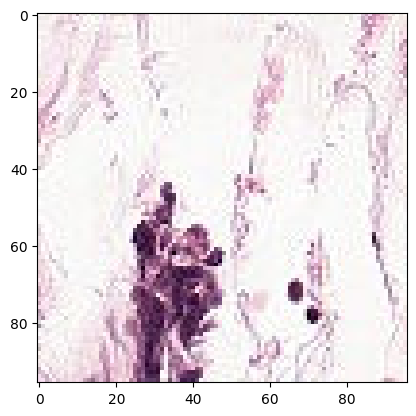

In [7]:
im = Image.open(train_img_directory +'/'+ train_labels['id'][1] + '.tif')
image_label = train_labels['label'][1]
print(f'label for the image is: {image_label}, this is a Cancer image')
width, height = im.size
print(f'the width of the image is : {width}')
print(f'the height of the image is :{height}')
plt.imshow(im)


(96, 96, 3)


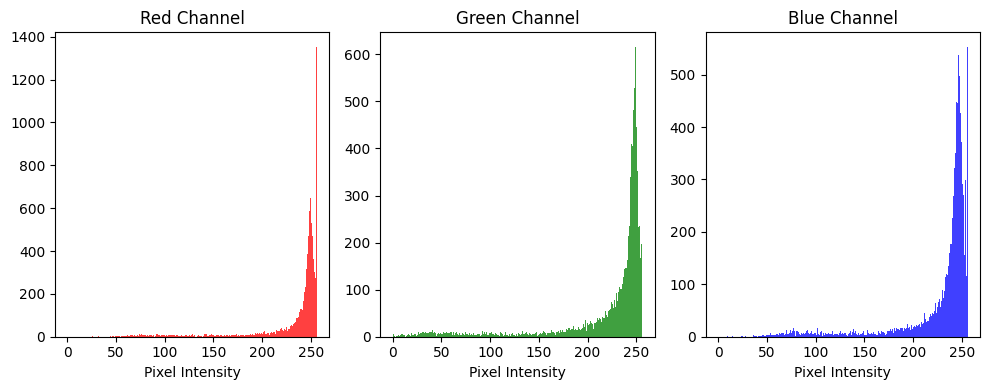

In [8]:
#### We will make a pixel intensity map to see the pixel intensity of the image above, the intensity can have patterns that will be picked up by the GAN
#### Inspired by the analysis done in https://www.codementor.io/@innat_2k14/image-data-analysis-using-numpy-opencv-part-1-kfadbafx6 
pixel_values = np.array(im)
print(pixel_values.shape)

# Separate the RGB channels
r, g, b = pixel_values[:,:,0], pixel_values[:,:,1], pixel_values[:,:,2]

# Plot the histogram of pixel intensities for each channel
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)  # Red channel
plt.hist(r.flatten(), bins=256, range=(0, 256), color='red', alpha=0.75)
plt.title('Red Channel')
plt.xlabel('Pixel Intensity')

plt.subplot(1, 3, 2)  # Green channel
plt.hist(g.flatten(), bins=256, range=(0, 256), color='green', alpha=0.75)
plt.title('Green Channel')
plt.xlabel('Pixel Intensity')

plt.subplot(1, 3, 3)  # Blue channel
plt.hist(b.flatten(), bins=256, range=(0, 256), color='blue', alpha=0.75)
plt.title('Blue Channel')
plt.xlabel('Pixel Intensity')

plt.tight_layout()
plt.show()

In [7]:
train_labels['filename'] = train_labels['id'] + '.tif'
train_labels['label'] = train_labels['label'].astype(str)  

datagen = ImageDataGenerator(
    rotation_range=0,  
    shear_range=0.0,  
    zoom_range=0.0,  
    fill_mode='nearest', 
    validation_split=0.2  
)

## Flow training images in batches of 32 using train_data_gen generator
## this is because it is time consuming and consumes lots of memory to load it all in a t the same time
train_generator = datagen.flow_from_dataframe(
    dataframe= train_labels,
    directory= train_img_directory,
    x_col="filename",
    y_col="label",
    subset="training",
    batch_size=32,
    shuffle=True,
    class_mode="binary",
    target_size=(96, 96)  
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory=train_img_directory,
    x_col="filename",
    y_col="label",
    subset="validation", 
    batch_size=32,
    shuffle=True,  
    class_mode="binary",
    target_size=(96, 96)
)

print(f'Number of training images: {train_generator.samples}')
print(f'Number of validation images: {validation_generator.samples}')

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Number of training images: 176020
Number of validation images: 44005


In [4]:
test_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,  
    shear_range=0.0,  
    zoom_range=0.1,  
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True
)

test_generator = test_datagen.flow_from_directory(
    directory=test_img_directory,  
    batch_size=32, 
    shuffle=False,
    class_mode=None,
    classes=['.'],
    target_size=(96, 96)  
)
print(f'Number of test images: {test_generator.samples}')

Found 57458 images belonging to 1 classes.
Number of test images: 57458


For the initial architecture, I will have a CNN with 2 convolution layers, with a max pooling layer after each convolution layer. Afterwards, there will be the classification layers which will be the ones to actually make the classification by interpreting the features extracted in the convolution layers and output the predicted label. 

First, I choose relu as the activation for all layers except the final dense layer, which acts as output layer that actually makes the binary classification. Relu was chosen because it adds non-linearity to the model, which allows the layers to learn complex patterns and better classify the data later in the classification layer. The output layer was a sigmoid activation layer because sigmoids output a number between 0 and 1, which would represent the probability that the input belongs to the positive class, or label "1". This then outputs whatever binary class it was. 

There is two convolution layers to start because one convolution layer might be too simple to capture all relevant interactions in the data, potentially leading to underfitting. Three layers or more for convolution might begin to overfit the data, since more complex interactions will be extracted but there is no guarantee that those complex interactions play a role in the test data while less complex patterns generally have a better chance of being found in other datasets. Some complex interactions might only be relevant in the training data and more convolution layers make the model more sensitive to them. Two convolution layers is a good middle-ground that can help serve as a starting point to see whether the data is underfitting or overfitting, which can help decide what modifications to make to the architecture later.

Finally, Max pooling was used after every convolution layer because max pooling takes the max value of the pooling window, making the model less prone to overfitting. This is because less noise passes through, since only the max value is acquired. Other pooling methods, like average pooling, let more noise pass through to the next layers. If there is no overfitting, this can be potentially changed to another pooling method as a potential improvement to the model.


In [20]:
## Modularized function to graph a metric based on the fitted model's history
def plot_metrics_graph(metric, x_label, title):
    plt.plot(metric)
    plt.title(title)
    plt.ylabel(x_label)
    plt.xlabel('Epoch')
    plt.legend(['Train'], loc='upper left')
    plt.show()
    
## Function to create a submission csv
def submit_csv(name, test_pred):    
    submission['label'] = test_pred
    submission.to_csv(name, index=False)

In [12]:
# Define the CNN architecture
def CNN_simple():
    model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [17]:
# Configure the checkpoint to save the model weights
checkpoint = ModelCheckpoint(
    'simple_checkpoint.h5',  
    monitor= 'auc',  
    save_best_only=True, 
    save_weights_only=False,  
    verbose=1,
    mode='max'
)

model_simple = CNN_simple()

model_simple.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy',tf.keras.metrics.AUC(name='auc')])

history_simple = model_simple.fit(train_generator, validation_data = validation_generator, epochs=4, callbacks=[checkpoint])

Epoch 1/4
5501/5501 [==============================] - ETA: 0s - loss: 1.0021 - accuracy: 0.5938 - auc: 0.5139
Epoch 1: auc improved from -inf to 0.51394, saving model to simple_checkpoint.h5
5501/5501 [==============================] - 1783s 324ms/step - loss: 1.0021 - accuracy: 0.5938 - auc: 0.5139 - val_loss: 0.6745 - val_accuracy: 0.5961 - val_auc: 0.5000
Epoch 2/4


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5501/5501 [==============================] - ETA: 0s - loss: 0.6751 - accuracy: 0.5947 - auc: 0.4999
Epoch 2: auc did not improve from 0.51394
5501/5501 [==============================] - 1710s 311ms/step - loss: 0.6751 - accuracy: 0.5947 - auc: 0.4999 - val_loss: 0.6746 - val_accuracy: 0.5961 - val_auc: 0.5000
Epoch 3/4
5501/5501 [==============================] - ETA: 0s - loss: 0.6751 - accuracy: 0.5947 - auc: 0.4981
Epoch 3: auc did not improve from 0.51394
5501/5501 [==============================] - 1511s 275ms/step - loss: 0.6751 - accuracy: 0.5947 - auc: 0.4981 - val_loss: 0.6745 - val_accuracy: 0.5961 - val_auc: 0.5000
Epoch 4/4
5501/5501 [==============================] - ETA: 0s - loss: 0.7286 - accuracy: 0.5947 - auc: 0.5012
Epoch 4: auc did not improve from 0.51394
5501/5501 [==============================] - 1477s 269ms/step - loss: 0.7286 - accuracy: 0.5947 - auc: 0.5012 - val_loss: 0.6747 - val_accuracy: 0.5961 - val_auc: 0.5000


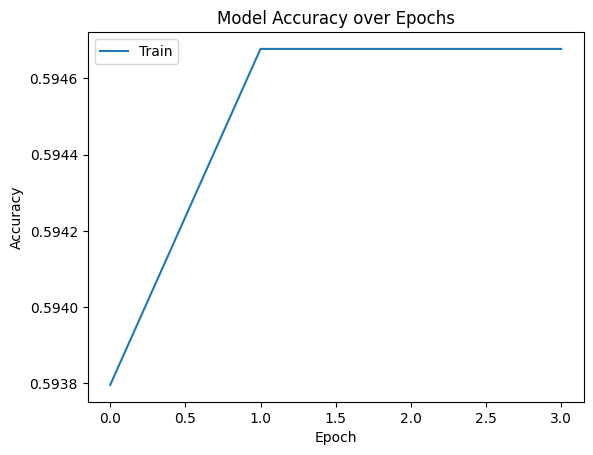

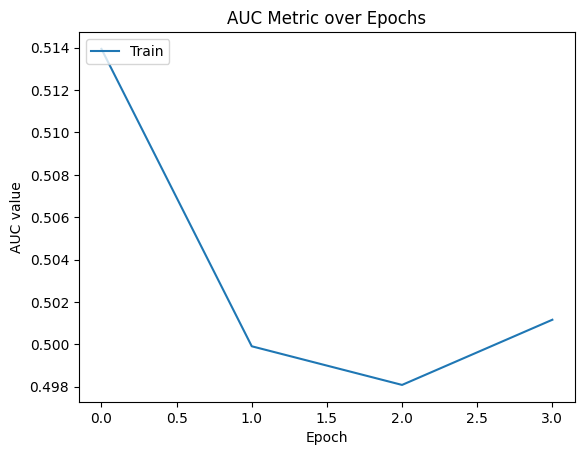

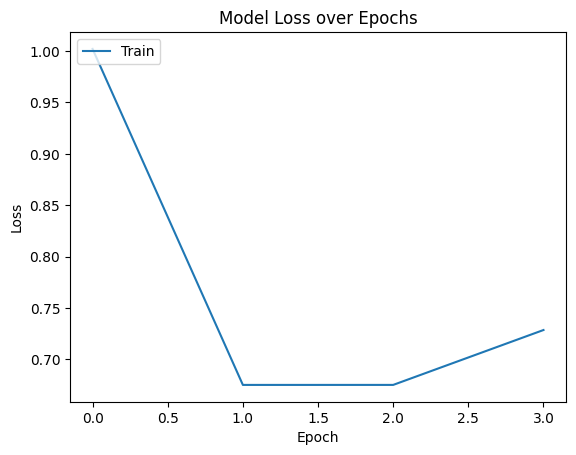

In [18]:
plot_metrics_graph(history_simple.history['accuracy'], 'Accuracy', 'Model Accuracy over Epochs')
plot_metrics_graph(history_simple.history['auc'], 'AUC value', 'AUC Metric over Epochs')
plot_metrics_graph(history_simple.history['loss'], 'Loss', 'Model Loss over Epochs')

The simple model does not learn anything. The model seems to be underfitting, not learning the underlying patterns needed to be able to make predictions. The simple model was fitted multiple times, getting significantly different results sometimes. Sometimes, the model managed to get auc in 0.90's range for the training set while there was times it got 0.5 auc like the final fitting of the simple model. This is because the simple model is very reliant on initial weights, which determine the local minima that the model will take. If it is initialized with the wrong weights, the local minima will be much worse and may even become stuck at some point unable to converge.

I am now going to test a more complex model with 3 convolution layers instead of 2. I am testing the more complex model to see the impact it will have on AUC. Since the simple model did badly due to underfitting, there is less of a risk of overfitting by making the model more complex though the risk still exists. The maxpooling will help reduce the risk of overfitting than other forms of pooling, however, there is still a bigger risk of overfitting with the addition of an extra convolutional layer. There is also the risk that the more complex model cannot understand the more complex interactions it will see, which is more likely to happen if the images have lots of noise, since a more complex model will be more sensitive to smaller bits of data which can oftentimes be noise. 

Batch normalization will be used in the new three layered model to speed up convergence due to its minimizing of the internal covariate shift allowing for faster learning rates. Batch normalization works by calculating the mean and variance for each feature in a mini-batch and then normalizing the features. Batch normalization also acts as a small regularizer, reducing the risk of overfitting. In addition, it also helps reduce sensitivity to initialization weights. These are all significant problems in the simple model that will be alleviated to a degree with batch normalization. 

In [12]:
# Define the CNN architecture
def CNN_Threecov():
    model = models.Sequential([
    layers.Conv2D(32, (3, 3), input_shape=(96, 96, 3)),
    layers.BatchNormalization(),  
    layers.Activation('relu'), 
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3)),
    layers.BatchNormalization(),
    layers.Activation('relu'), 
    layers.MaxPooling2D((2, 2)),
        
    layers.Conv2D(32, (3, 3)),
    layers.BatchNormalization(), 
    layers.Activation('relu'), 
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    
    layers.Dense(64),
    layers.BatchNormalization(),  
    layers.Activation('relu'),    
    layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [13]:
# Configure the checkpoint to save the model weights
checkpoint = ModelCheckpoint(
    'three_checkpoint.h5',  
    monitor= 'auc',  
    save_best_only=True, 
    save_weights_only=False,  
    verbose=1,
    mode='max'
)

model_three = CNN_Threecov()

model_three.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy',tf.keras.metrics.AUC(name='auc')])

history_three = model_three.fit(train_generator, validation_data = validation_generator, epochs=4, callbacks=[checkpoint])

Epoch 1/4
5501/5501 [==============================] - ETA: 0s - loss: 0.3501 - accuracy: 0.8490 - auc: 0.9205
Epoch 1: auc improved from -inf to 0.92053, saving model to three_checkpoint.h5
5501/5501 [==============================] - 2546s 462ms/step - loss: 0.3501 - accuracy: 0.8490 - auc: 0.9205 - val_loss: 0.5315 - val_accuracy: 0.7767 - val_auc: 0.8973
Epoch 2/4


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5501/5501 [==============================] - ETA: 0s - loss: 0.2658 - accuracy: 0.8921 - auc: 0.9541
Epoch 2: auc improved from 0.92053 to 0.95412, saving model to three_checkpoint.h5
5501/5501 [==============================] - 2223s 404ms/step - loss: 0.2658 - accuracy: 0.8921 - auc: 0.9541 - val_loss: 0.4277 - val_accuracy: 0.8253 - val_auc: 0.9401
Epoch 3/4
5501/5501 [==============================] - ETA: 0s - loss: 0.2225 - accuracy: 0.9121 - auc: 0.9675
Epoch 3: auc improved from 0.95412 to 0.96754, saving model to three_checkpoint.h5
5501/5501 [==============================] - 2069s 376ms/step - loss: 0.2225 - accuracy: 0.9121 - auc: 0.9675 - val_loss: 0.2060 - val_accuracy: 0.9210 - val_auc: 0.9726
Epoch 4/4
5501/5501 [==============================] - ETA: 0s - loss: 0.1971 - accuracy: 0.9231 - auc: 0.9743
Epoch 4: auc improved from 0.96754 to 0.97434, saving model to three_checkpoint.h5
5501/5501 [==============================] - 2175s 395ms/step - loss: 0.1971 - accuracy:

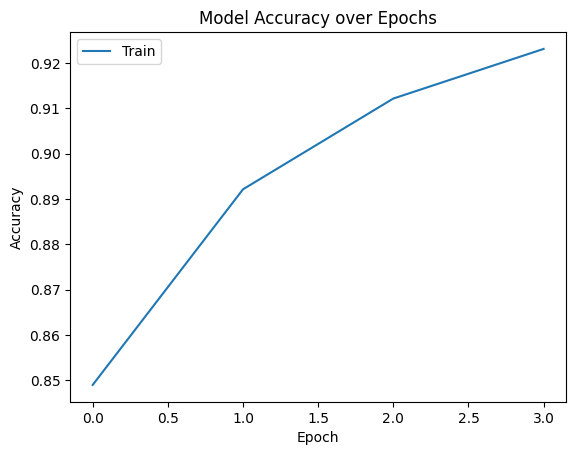

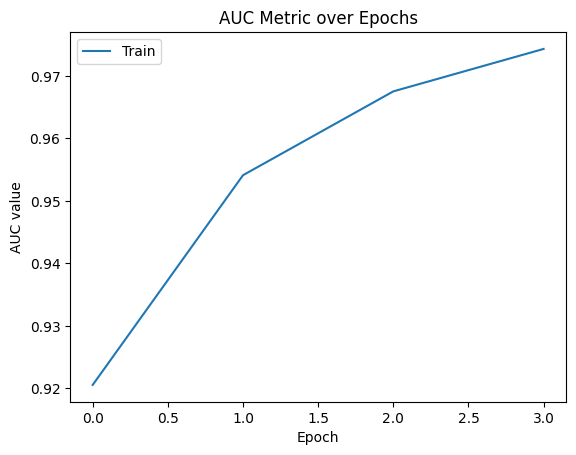

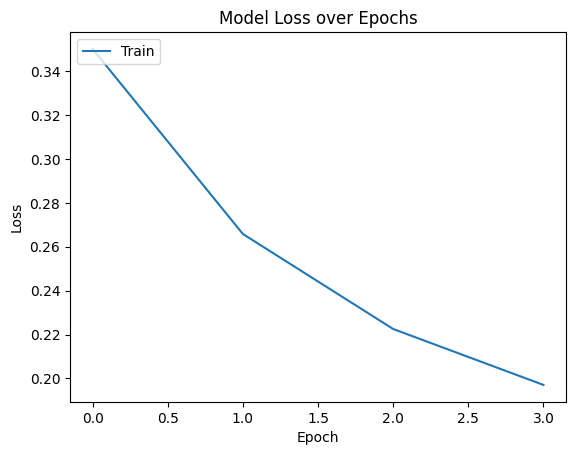

In [14]:
plot_metrics_graph(history_three.history['accuracy'], 'Accuracy', 'Model Accuracy over Epochs')
plot_metrics_graph(history_three.history['auc'], 'AUC value', 'AUC Metric over Epochs')
plot_metrics_graph(history_three.history['loss'], 'Loss', 'Model Loss over Epochs')

As can be seen above, the final test auc in the last epoch was 0.97 and the accuracy was 0.92, which is very good at first glance. This, however, is very high auc and accuracy for the training set and is suspiciously high enough to warrant the exploration of whether the model is overfitting a significant amount. A hint of overfitting can be seen in the epoch print statement below: 

Epoch 3/4
5501/5501 - 2069s 376ms/step - loss: 0.2225 - accuracy: 0.9121 - auc: 0.9675 - val_loss: 0.2060 - val_accuracy: 0.9210 - val_auc: 0.9726

Epoch 4/4
5501/5501 [- 2175s 395ms/step - loss: 0.1971 - accuracy: 0.9231 - auc: 0.9743 - val_loss: 0.8069 - val_accuracy: 0.7164 - val_auc: 0.9067

As can be seen in the epoch print statements, while the training set accuracy and auc gradually increased, the validation set's accuracy and auc were significantly lower. The validation loss was also significantly higher. Given the significant accuracy gap of more than 20% from validation accuracy to training accuracy, it seems that the final epoch led to significant overfitting of the training data. This means that it is likely the model will also overfit significantly on the test data, which is the opposite problem of the simpleRNN two layer model, which was underfitting and not learning information.

In [16]:
y_pred = model_three.predict(test_generator)
predicted_labels = (y_pred > 0.5).astype(int).flatten()

1796/1796 [==============================] - 290s 161ms/step


In [17]:
submit_csv('three.csv', predicted_labels)

Has can be seen, the more complex model did much worse in AUC in the test set, with a 0.5 auc. This is probably because making the model more complex made the model find more complex interactions but the model could not generalize those complex interactions because they were specific to the training set. Adding the extra convolution layer also made the noise more pronounced. 

To improve on overfitting, we will use early stopping, since it can be seen that the last epoch overfitted due to the significant decrease in validation accuracy and validation auc. We will also increase the size of the validation set to 0.25 instead of just 0.2, to be able to better judge the training fit. This is because even though it can be seen that moderate overfitting occurred in the last epoch, it does not explain the random guessing auc seen in the test set, which means early stopping by itself is not going to remove all the overfitting. Since the validation set auc was also high, perhaps it was not large enough to be more representative of unseen data. We will first see the effects of early stopping modifications to the next model, then we will implement a dropout layer afterwards to more effectively measure the effects of the modifications to the overfitting of the model and test set auc.


In [7]:
train_labels['filename'] = train_labels['id'] + '.tif'
train_labels['label'] = train_labels['label'].astype(str)  

datagen = ImageDataGenerator(
    rotation_range=0,  
    shear_range=0.0,  
    zoom_range=0.0,  
    fill_mode='nearest', 
    validation_split=0.25  
)

## Flow training images in batches of 32 using train_data_gen generator
## this is because it is time consuming and consumes lots of memory to load it all in at the same time
train_generator = datagen.flow_from_dataframe(
    dataframe= train_labels,
    directory= train_img_directory,
    x_col="filename",
    y_col="label",
    subset="training",
    batch_size=32,
    shuffle=True,
    class_mode="binary",
    target_size=(96, 96)  
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory=train_img_directory,
    x_col="filename",
    y_col="label",
    subset="validation", 
    batch_size=32,
    shuffle=True,  
    class_mode="binary",
    target_size=(96, 96)
)

print(f'Number of training images: {train_generator.samples}')
print(f'Number of validation images: {validation_generator.samples}')

Found 165019 validated image filenames belonging to 2 classes.
Found 55006 validated image filenames belonging to 2 classes.
Number of training images: 165019
Number of validation images: 55006


In [19]:
# Define the CNN architecture
def CNN_Threecov():
    model = models.Sequential([
    layers.Conv2D(32, (3, 3), input_shape=(96, 96, 3)),
    layers.BatchNormalization(),  
    layers.Activation('relu'), 
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3)),
    layers.BatchNormalization(),
    layers.Activation('relu'), 
    layers.MaxPooling2D((2, 2)),
        
    layers.Conv2D(32, (3, 3)),
    layers.BatchNormalization(), 
    layers.Activation('relu'), 
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    
    layers.Dense(64),
    layers.BatchNormalization(),  
    layers.Activation('relu'),    
    layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [22]:
early_stopping = EarlyStopping(
    monitor='val_auc',  
    min_delta=0.01, 
    patience=0, 
    verbose=1,
    restore_best_weights=True  
)

 #Configure the checkpoint to save the model weights
checkpoint = ModelCheckpoint(
    'stopping_checkpoint.h5',  
    monitor= 'val_auc',  
    save_best_only=True, 
    save_weights_only=False,  
    verbose=1,
    mode='max'
)

model_stop = CNN_Threecov()

model_stop.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy',tf.keras.metrics.AUC(name='auc')])

history_stop = model_stop.fit(train_generator, validation_data = validation_generator, epochs=4, callbacks=[checkpoint, early_stopping])


Epoch 1/4
5157/5157 [==============================] - ETA: 0s - loss: 0.3517 - accuracy: 0.8488 - auc: 0.9196
Epoch 1: val_auc improved from -inf to 0.88709, saving model to stopping_checkpoint.h5
5157/5157 [==============================] - 2229s 432ms/step - loss: 0.3517 - accuracy: 0.8488 - auc: 0.9196 - val_loss: 0.4369 - val_accuracy: 0.7970 - val_auc: 0.8871
Epoch 2/4


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5157/5157 [==============================] - ETA: 0s - loss: 0.2715 - accuracy: 0.8894 - auc: 0.9521
Epoch 2: val_auc improved from 0.88709 to 0.93082, saving model to stopping_checkpoint.h5
5157/5157 [==============================] - 2243s 435ms/step - loss: 0.2715 - accuracy: 0.8894 - auc: 0.9521 - val_loss: 0.3292 - val_accuracy: 0.8577 - val_auc: 0.9308
Epoch 3/4
5157/5157 [==============================] - ETA: 0s - loss: 0.2255 - accuracy: 0.9111 - auc: 0.9666
Epoch 3: val_auc improved from 0.93082 to 0.95578, saving model to stopping_checkpoint.h5
5157/5157 [==============================] - 2235s 433ms/step - loss: 0.2255 - accuracy: 0.9111 - auc: 0.9666 - val_loss: 0.2586 - val_accuracy: 0.8988 - val_auc: 0.9558
Epoch 4/4
5157/5157 [==============================] - ETA: 0s - loss: 0.1987 - accuracy: 0.9232 - auc: 0.9737
Epoch 4: val_auc improved from 0.95578 to 0.96886, saving model to stopping_checkpoint.h5
5157/5157 [==============================] - 2161s 419ms/step - los

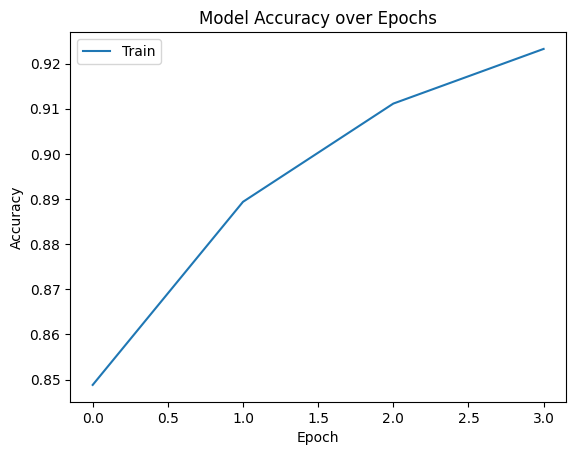

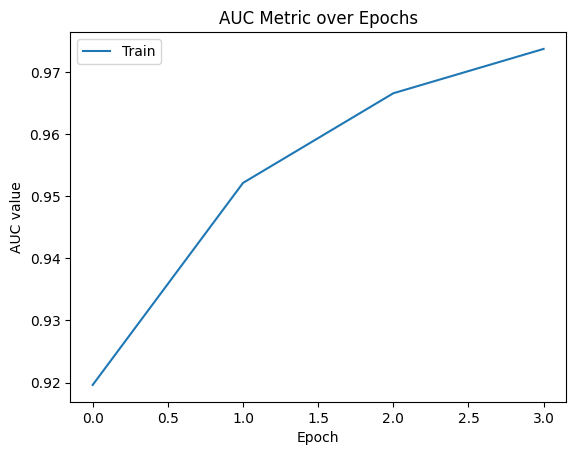

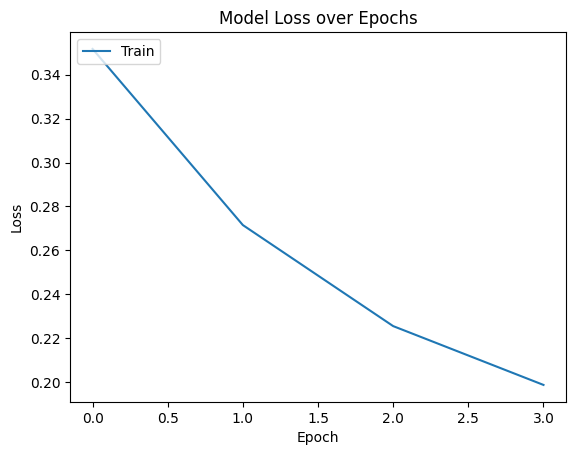

In [23]:
plot_metrics_graph(history_stop.history['accuracy'], 'Accuracy', 'Model Accuracy over Epochs')
plot_metrics_graph(history_stop.history['auc'], 'AUC value', 'AUC Metric over Epochs')
plot_metrics_graph(history_stop.history['loss'], 'Loss', 'Model Loss over Epochs')

In [35]:
y_pred = model_stop.predict(test_generator)

1796/1796 [==============================] - 224s 125ms/step


In [36]:
submit_csv('stop.csv', y_pred)

The model still has a 0.5 test auc, which makes sense since it still overfits significantly and the model did not early stop in this iteration of the model because the validation loss never got worse.

Epoch 1/4
5157/5157 [==============================] - 2229s 432ms/step - loss: 0.3517 - accuracy: 0.8488 - auc: 0.9196 - val_loss: 0.4369 - val_accuracy: 0.7970 - val_auc: 0.8871

Epoch 2/4
5157/5157 [==============================] - 2243s 435ms/step - loss: 0.2715 - accuracy: 0.8894 - auc: 0.9521 - val_loss: 0.3292 - val_accuracy: 0.8577 - val_auc: 0.9308

Epoch 3/4
5157/5157 [==============================] - 2235s 433ms/step - loss: 0.2255 - accuracy: 0.9111 - auc: 0.9666 - val_loss: 0.2586 - val_accuracy: 0.8988 - val_auc: 0.9558

Epoch 4/4
5157/5157 [==============================] - 2161s 419ms/step - loss: 0.1987 - accuracy: 0.9232 - auc: 0.9737 - val_loss: 0.2304 - val_accuracy: 0.9090 - val_auc: 0.9689

As can be seen, the validation set seems to be doing well, yet, it still completely overfits. This is apparent with the overwhelmingly high auc score in only the first epoch of the model. A valid model that is generalizable would take a few epochs before it managed to gain such a large auc, some may never even reach it. 

This means that the model still requires significant regularization to be able to have a higher auc in the test set. dropout, which is a technique that randomly deactivates a random portion of neurons during training, reducing models possible reliance on a handful features and allowing more robust feature learning. I will add a dropout layer to each convolution layer and a dropout layer to the dense layer. These adjustments should dramatically decrease the overfitting of the model and combined with early stoppage, get more optimal weights that are more generalizable.

I will also be halving the neurons in the every convolution layer because I had done a pyramid structure where it got more neurons in the 2nd layer and then decreased in the 3rd layer. The structure was like that because it would get more complex features in the 2nd layer and then get the most important ones in the 3rd layer. It will now get more complex interactions progressively when it gets deeper. I also halved the neurons because the overfitting was significant, so dropout may not be enough regularization by itself. With the addition of dropout in every layer and halving the neurons, overfitting should be immensely controlled.

In [1]:
# Define the CNN architecture
def CNN_dropd():
    model = models.Sequential([
    layers.Conv2D(16, (3, 3), input_shape=(96, 96, 3)),
    layers.Conv2D(16, (3, 3), input_shape=(96, 96, 3)),
    layers.BatchNormalization(),  
    layers.Activation('relu'),
    layers.Dropout(0.3),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(32, (3, 3)),
    layers.Conv2D(32, (3, 3)),
    layers.BatchNormalization(),
    layers.Activation('relu'), 
    layers.Dropout(0.3),
    layers.MaxPooling2D((2, 2)),
        
    layers.Conv2D(64, (3, 3)),
    layers.Conv2D(64, (3, 3)),
    layers.BatchNormalization(), 
    layers.Activation('relu'), 
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Flatten(),
    
    layers.Dense(128),
    layers.BatchNormalization(),  
    layers.Activation('relu'), 
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
    ])
    
    return model



In [2]:
early_stopping = EarlyStopping(
    monitor='val_auc',  
    min_delta=0.01, 
    patience=0, 
    verbose=1,
    restore_best_weights=True  
)

 #Configure the checkpoint to save the model weights
checkpoint = ModelCheckpoint(
    'dropout_checkpoint.h5',  
    monitor= 'val_auc',  
    save_best_only=True, 
    save_weights_only=False,  
    verbose=1,
    mode='max'
)

model_drop = CNN_dropd()

model_drop.compile(optimizer=Adam(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy',tf.keras.metrics.AUC(name='auc')])

history_drop = model_drop.fit(train_generator, validation_data = validation_generator, epochs=4, callbacks=[checkpoint, early_stopping])


NameError: name 'EarlyStopping' is not defined

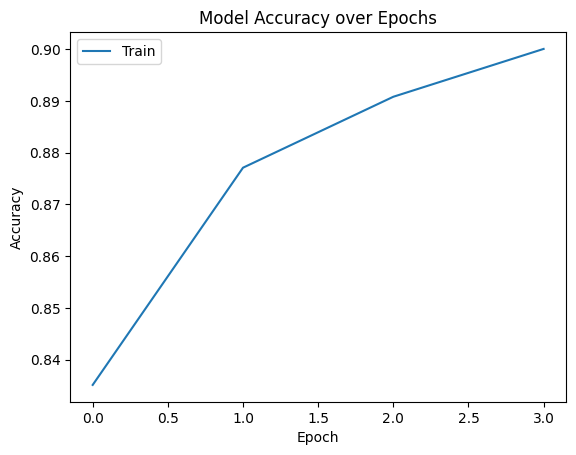

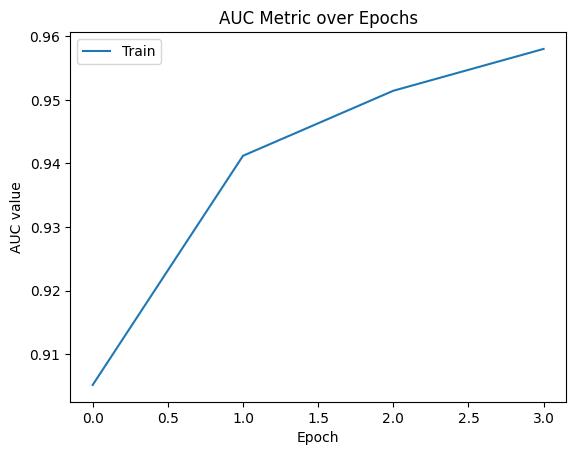

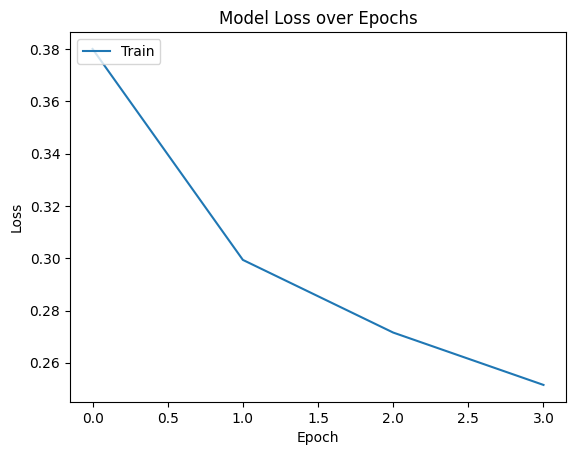

In [15]:
plot_metrics_graph(history_drop.history['accuracy'], 'Accuracy', 'Model Accuracy over Epochs')
plot_metrics_graph(history_drop.history['auc'], 'AUC value', 'AUC Metric over Epochs')
plot_metrics_graph(history_drop.history['loss'], 'Loss', 'Model Loss over Epochs')

In [16]:
y_pred = model_drop.predict(test_generator)

1796/1796 [==============================] - 633s 352ms/step


In [17]:
submit_csv('drop.csv', y_pred)

An important thing to note is that we did not do much image pre-processing beforehand, such as normalizing images, flipping them, and rotating them. increased dropout before dense layer to prevent overfitting, still overfits alot.

In [6]:
train_labels['filename'] = train_labels['id'] + '.tif'
train_labels['label'] = train_labels['label'].astype(str)  

train_df, test_df = train_test_split(train_labels, random_state=24)
ncat_bal = train_df['label'].value_counts().max()
train_df = train_df.groupby('label', as_index=False).apply(lambda g:  g.sample(ncat_bal, replace=True, random_state=24)).reset_index(drop=True)
        
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,  
    shear_range=0.0,  
    zoom_range=0.1,  
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.25  
)

## Flow training images in batches of 32 using train_data_gen generator
## this is because it is time consuming and consumes lots of memory to load it all in at the same time
train_generator = datagen.flow_from_dataframe(
    dataframe= train_labels,
    directory= train_img_directory,
    x_col="filename",
    y_col="label",
    subset="training",
    batch_size=32,
    shuffle=True,
    class_mode="binary",
    target_size=(96, 96)  
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory=train_img_directory,
    x_col="filename",
    y_col="label",
    subset="validation", 
    batch_size=32,
    shuffle=True,  
    class_mode="binary",
    target_size=(96, 96)
)

print(f'Number of training images: {train_generator.samples}')
print(f'Number of validation images: {validation_generator.samples}')

/tmp/ipykernel_34/3530665913.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = train_df.groupby('label', as_index=False).apply(lambda g:  g.sample(ncat_bal, replace=True, random_state=24)).reset_index(drop=True)


Found 165019 validated image filenames belonging to 2 classes.
Found 55006 validated image filenames belonging to 2 classes.
Number of training images: 165019
Number of validation images: 55006


In [17]:
# Define the CNN architecture LOOKS LIKE BALANCING THE CLASSES MIGHT ALSO BE PART OF THE ISSUE
def CNN_final():
    model = models.Sequential([
    layers.Conv2D(16, (3, 3), input_shape=(96, 96, 3)),
    layers.Conv2D(16, (3, 3)),
    layers.BatchNormalization(),  
    layers.Activation('relu'),
    layers.Dropout(0.3),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(32, (3, 3)),
    layers.Conv2D(32, (3, 3)),
    layers.BatchNormalization(),
    layers.Activation('relu'), 
    layers.Dropout(0.3),
    layers.MaxPooling2D((2, 2)),
        
    layers.Conv2D(64, (3, 3)),
    layers.Conv2D(64, (3, 3)),
    layers.BatchNormalization(), 
    layers.Activation('relu'), 
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Flatten(),
    
    layers.Dense(128),
    layers.BatchNormalization(),  
    layers.Activation('relu'), 
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')
    ])
    
    return model


In [18]:
early_stopping = EarlyStopping(
    monitor='val_auc',  
    min_delta=0.01, 
    patience=0, 
    verbose=1,
    restore_best_weights=True  
)

 #Configure the checkpoint to save the model weights
checkpoint = ModelCheckpoint(
    'final_checkpoint.h5',  
    monitor= 'val_auc',  
    save_best_only=True, 
    save_weights_only=False,  
    verbose=1,
    mode='max'
)

model_final = CNN_finalr()

model_final.compile(optimizer=Adam(lr=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy',tf.keras.metrics.AUC(name='auc')])

history_final = model_final.fit(train_generator, validation_data = validation_generator, epochs=4, callbacks=[checkpoint, early_stopping])


Epoch 1/4


2024-03-05 03:43:29.138506: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/dropout_15/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


5157/5157 [==============================] - ETA: 0s - loss: 0.3885 - accuracy: 0.8322 - auc: 0.9012
Epoch 1: val_auc improved from -inf to 0.91588, saving model to final_checkpoint.h5
5157/5157 [==============================] - 1060s 205ms/step - loss: 0.3885 - accuracy: 0.8322 - auc: 0.9012 - val_loss: 0.4584 - val_accuracy: 0.8138 - val_auc: 0.9159
Epoch 2/4
5157/5157 [==============================] - ETA: 0s - loss: 0.3065 - accuracy: 0.8733 - auc: 0.9386
Epoch 2: val_auc did not improve from 0.91588
Restoring model weights from the end of the best epoch: 1.
5157/5157 [==============================] - 1050s 204ms/step - loss: 0.3065 - accuracy: 0.8733 - auc: 0.9386 - val_loss: 0.4102 - val_accuracy: 0.8149 - val_auc: 0.9143
Epoch 2: early stopping


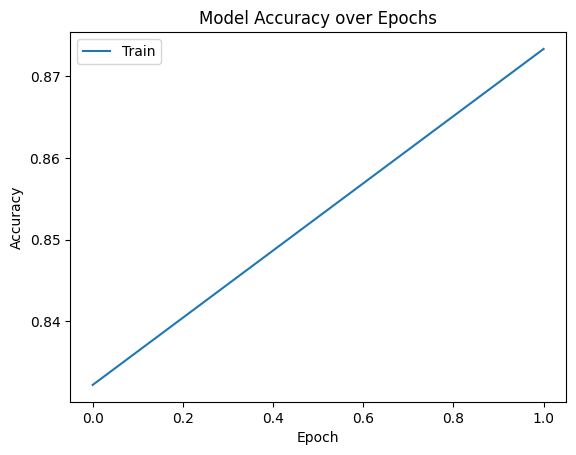

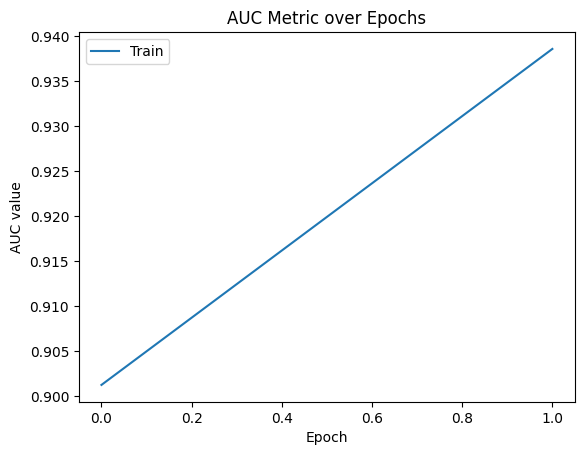

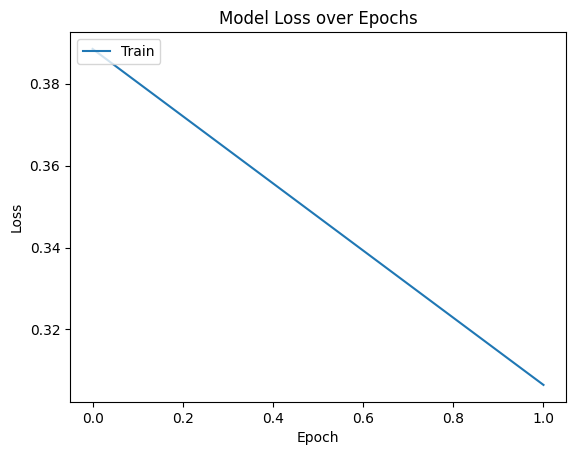

In [22]:
plot_metrics_graph(history_final.history['accuracy'], 'Accuracy', 'Model Accuracy over Epochs')
plot_metrics_graph(history_final.history['auc'], 'AUC value', 'AUC Metric over Epochs')
plot_metrics_graph(history_final.history['loss'], 'Loss', 'Model Loss over Epochs')

In [23]:
y_pred = model_final.predict(test_generator)

1796/1796 [==============================] - 659s 367ms/step


In [24]:
submit_csv('final.csv', y_pred)

Finally, I am gonna try and see the effects of changing the pooling layers of the architecture. Currently, the pooling layer does max pooling for the architectures and models that have been tested. Average pooling is less aggressive with its downsampling since it calculates the average of the values in the pooling window instead of only retaining the maximum value. This means it retains more information from the input. This fact also makes models with average pooling more prone to noise, since the input information that is retained will also be much more likely to contain noise than the max pooling. 

The next architecture will be using average pooling instead of max pooling, with the result depending on how much noise the data contains. If the data contains too much noise, then average pooling will perform worse than the max pooling architectures. 

In [47]:
# Define the CNN architecture
def CNN_pool():
    model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.AveragePooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.AveragePooling2D((2, 2)),
    layers.Flatten(),
    
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [48]:
model_pool = CNN_pool()

model_pool.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy',tf.keras.metrics.AUC(name='auc')])

history_pool = model_pool.fit(train_generator,epochs=5)

Epoch 1/5
6876/6876 [==============================] - 2653s 386ms/step - loss: 0.8603 - accuracy: 0.6761 - auc: 0.7425
Epoch 2/5
6876/6876 [==============================] - 2664s 387ms/step - loss: 0.4714 - accuracy: 0.7828 - auc: 0.8528
Epoch 3/5
6876/6876 [==============================] - 2887s 420ms/step - loss: 0.4223 - accuracy: 0.8114 - auc: 0.8842
Epoch 4/5
6876/6876 [==============================] - 2822s 410ms/step - loss: 0.3995 - accuracy: 0.8238 - auc: 0.8971
Epoch 5/5
6876/6876 [==============================] - 2804s 408ms/step - loss: 0.3771 - accuracy: 0.8361 - auc: 0.9091


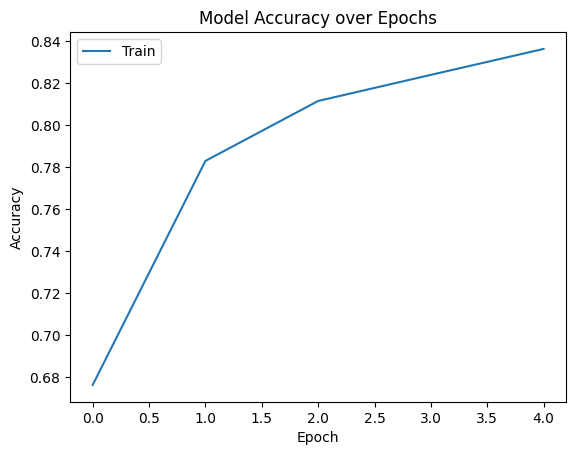

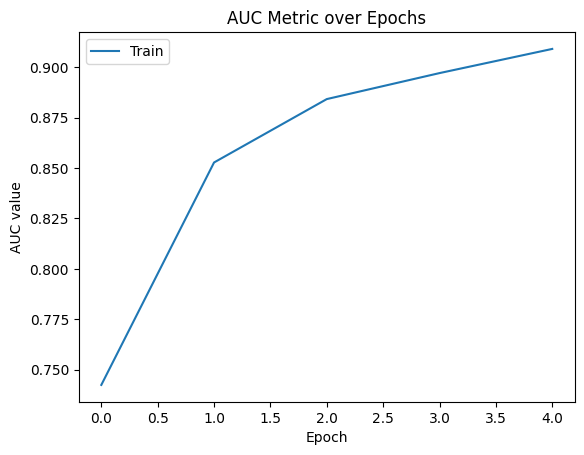

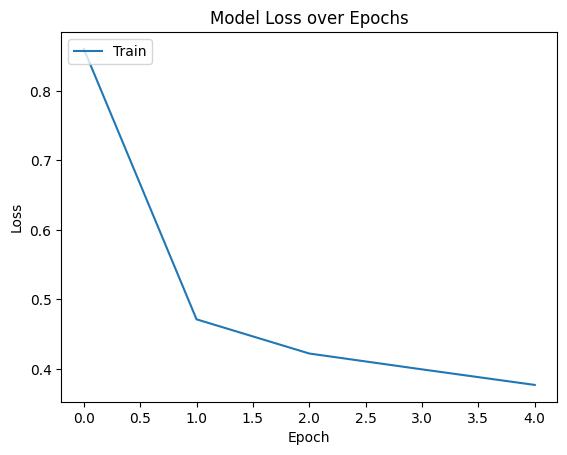

In [49]:
plot_metrics_graph(history_pool.history['accuracy'], 'Accuracy', 'Model Accuracy over Epochs')
plot_metrics_graph(history_pool.history['auc'], 'AUC value', 'AUC Metric over Epochs')
plot_metrics_graph(history_pool.history['loss'], 'Loss', 'Model Loss over Epochs')

In [66]:
y_pred = model_pool.predict(train_generator)
print

6876/6876 [==============================] - 919s 134ms/step


In [50]:
y_pred = model_pool.predict(test_generator)
predicted_labels = (y_pred > 0.5).astype(int).flatten()


1796/1796 [==============================] - 441s 245ms/step


In [ ]:
submission.to_csv('l.csv', index=False)

The average pooling model, once again, got 0.49 auc indicating severe overfitting. 

# **CONCLUSION**


| model | result
|----------|----------|
| simple   | underfit|
| three convolution layers and batch normalization   | overfit | 
| three convolution with early stopping    | overfit|
| added dropout layers   | overfit|
| data augmentation before model   | overfit|
| change pooling   | overfit |

In this dataset, I gradually improved each model. It began with a simple CNN with two convolution layers and eventually added regularization factors such as dropout. Since the models kept overfitting significantly, most of the improvements on the initial model were based on trying to control the overfitting of the last model. In the end, It resulted in very high training and validation auc and accuracy but very low auc for all the models that were tested.

Next time, I think that doing more data-preprocessing would be very helpful because the overfitting is more than likely stemming from the structure of the data and not so much from the architecture of the models themselves. For example, the training set in this project was unbalanced with a 60/40 split, which means that the majority class as a much bigger sample for a binary decision. This leads to the models training to pick the majority class more often than not, which is not ideal. I should have balanced classes and also normalized the images from the very beginning and not in my 2nd to last model. These preprocessing steps probably would have helped in figuring out the source of overfitting sooner.

In the future, I could potentially mix up kernel sizes since I did not modify the kernel sizes at all from my initial model. This could make the model more performant if tuned correctly.